In [7]:
import seaborn as sns
sns.set_theme(style="darkgrid", font_scale=1)

In [8]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

# assume that notebook located in the same directory as felere
from felere.common.simulation import Simulation
from felere.common.distributor import DataDistributor
from felere.common.datasets import FashionMNISTDataset

from felere.pipelines.pipeline import Pipeline

from felere.function.torch import TorchFunction
from felere.function.torch_models import FashionMNISTLinearModel

from felere.optimization.federative.api import BaseFederatedOptimizer

In [9]:
X, y = FashionMNISTDataset().generate(to_float=True)

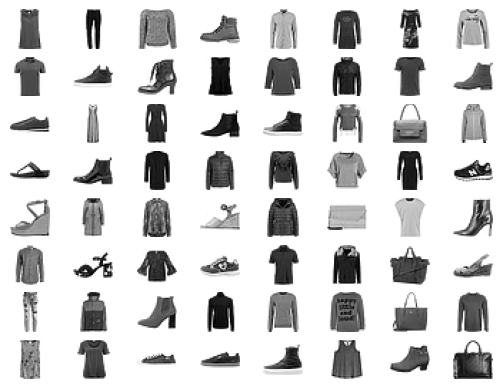

In [10]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    img = X[random.randint(0, X.shape[0])]

    plt.imshow(img, cmap=plt.cm.binary)

In [11]:
n_classes = len(np.unique(y))
print(f"{n_classes=}")

n_classes=10


In [12]:
n_features = X.shape[1] * X.shape[2]
n_targets = n_classes

In [13]:
print("reshaping X...")
X = np.float32(X).reshape((X.shape[0], X.shape[1] * X.shape[2]))
print(f"{X.dtype=}")

reshaping X...
X.dtype=dtype('float32')


In [14]:
print(f"{X.shape=}")

X.shape=(70000, 784)


In [15]:
torch_model = FashionMNISTLinearModel(n_features=n_features, n_targets=n_classes)
function = TorchFunction(torch_model, torch.nn.CrossEntropyLoss())

In [16]:
print(f"{torch_model.n_paramaters()=}")

torch_model.n_paramaters()=101770


In [17]:
distributor = DataDistributor(test_size=0.3, server_fraction=0.2)

In [18]:
class Custom(BaseFederatedOptimizer):
  def __init__(self, eta):
    self.eta: float = eta      
    
  def play_round(self, model: Simulation):
    _, clients_weights, other = model.clients_update(self.client_update)
    clients_n_samples = other["n_samples"]
      
    next_global_weights = \
      (clients_weights * clients_n_samples).sum(axis=0) / clients_n_samples.sum()
    
    model.server.function.update(
      (-1) * (model.server.function.weights() - next_global_weights)
    )

  def client_update(self, server, client):
    client.function.update(
      (-1) * (client.function.weights() - server.function.weights())
    )
    client.function(X=client.X, y=client.y)

    step = (-1) * self.eta * client.function.grad()
    client.function.update(step)
    
    client.other["n_samples"] = client.X.shape[0]
    return client
  

  def __repr__(self):
    return "CustomMethod"


CustomMethod for parameters:  n_clients=96,  iid_fraction=0.0,  clients_fraction=0.2,  rounds=16
 eta=0.005:


learning: 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


f1_score : 0.23931280467969301

CustomMethod for parameters:  n_clients=96,  iid_fraction=0.8,  clients_fraction=0.2,  rounds=16
 eta=0.005:


learning: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


f1_score : 0.24563411689552778
done


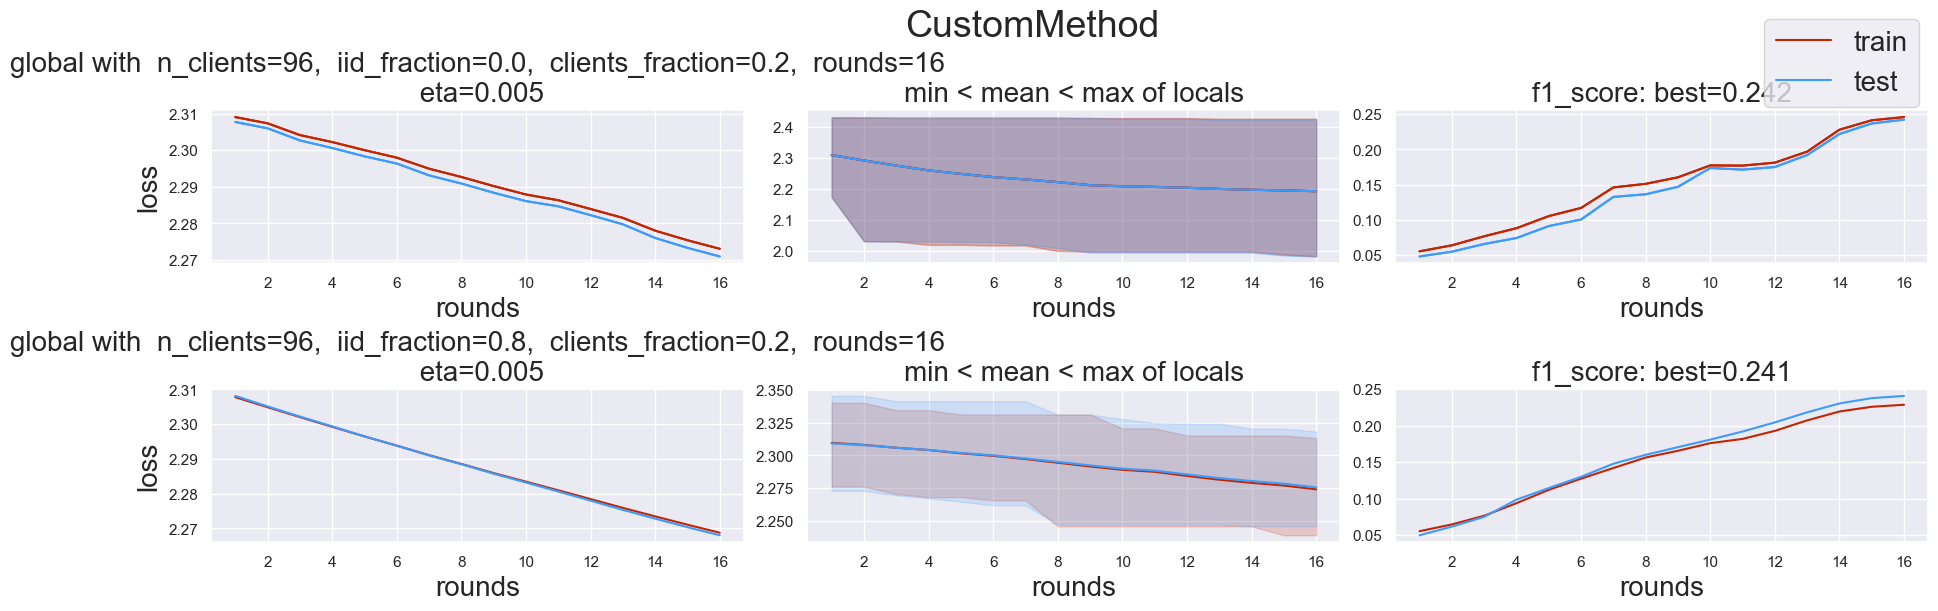

In [20]:
optimizer_parameters = {
  Custom : {
    "n_clients" : [96],
    "iid_fraction" : [0.0, 0.8],
    "clients_fraction": [0.2],
    "rounds": [16],
    "eta": [0.5e-2],
  }
}

metrics = {
  "f1_score" : lambda y_proba, y_true: f1_score(np.argmax(y_proba, axis=1), y_true, average="weighted")
}

pipeline = Pipeline(
  function=function,
  metrics=metrics,
  optimizer_parameters=optimizer_parameters,
  distributor=distributor,
  X=X,
  y=y,
  subplot_height=6,
  font_size=20
)

best, best_params = pipeline.run(choose_best_by="f1_score")

print("done")